In [1]:
import os
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization
from seaborn import scatterplot
import seaborn as sns
import numpy as np
import requests
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = 'data'
or_dir = '../data'
twin_dir = 'data/twin_comparison'
picrust_dir = 'data/picrust_del'

In [3]:
metadata = pd.read_csv(f'{or_dir}/metadata.tsv', sep='\t')
metadata.head()

,id,Library Layout,Instrument,collection_date,geo_location_name,geo_latitude,geo_longitude,host_id,age_days,weight_kg,...,birth_length_cm,sex,delivery_mode,zygosity,race,ethnicity,delivery_preterm,diet_milk,diet_weaning,age_months
0,ERR1314182,PAIRED,Illumina MiSeq,2011-11-11 00:00:00,"USA, Missouri, St. Louis",38.63699,-90.263794,42.1,232.0,NaN,...,47.0,male,Cesarean,Monozygotic,Caucasian,Not Hispanic,True,fd,True,8.0
1,ERR1314183,PAIRED,Illumina MiSeq,2010-12-11 00:00:00,"USA, Missouri, St. Louis",38.63699,-90.263794,27.2,192.0,NaN,...,45.0,female,Cesarean,Dizygotic,Caucasian,Hispanic,True,fd,True,6.0
2,ERR1314184,PAIRED,Illumina MiSeq,2011-12-11 00:00:00,"USA, Missouri, St. Louis",38.63699,-90.263794,28.1,536.0,NaN,...,51.0,female,Cesarean,Monozygotic,Caucasian,Not Hispanic,False,NaN,NaN,18.0
3,ERR1314185,PAIRED,Illumina MiSeq,2011-12-11 00:00:00,"USA, Missouri, St. Louis",38.63699,-90.263794,28.2,537.0,NaN,...,50.0,female,Cesarean,Monozygotic,Caucasian,Not Hispanic,False,NaN,NaN,18.0
4,ERR1314186,PAIRED,Illumina MiSeq,2013-01-12 00:00:00,"USA, Missouri, St. Louis",38.63699,-90.263794,39.2,688.0,NaN,...,48.0,male,Cesarean,Monozygotic,African-American,Not Hispanic,True,NaN,NaN,23.0


In [4]:
def fetch_ipath(ids: list, img_output_path: str, verbose: bool = False):
    """Fetches a enriched pathways map from iPATH3 for given IDs."""
    url = 'https://pathways.embl.de/mapping.cgi'
    
    # remove colon from EC names
    if ':' in ids[0]:
        ids = [x.replace(':', '') for x in ids]
    
    if verbose:
        print(f'Fetching iPATH3 diagram for ids: {ids}')
    params = {
        'default_opacity': 0.6,
        'export_type': 'svg',
        'selection': '\n'.join(ids)
    }   
    response = requests.get(url=url, params=params)
    
    with open(img_output_path, 'wb') as img:
        img.write(response.content)

In [5]:
# path to the picrust2 conda environment - do not change!
picrust_env = '/opt/conda/envs/picrust2/bin'

In [ ]:
%%script env picrust_env="$picrust_env" data_dir="$data_dir" bash

# append the env location to PATH so that qiime
# can find all required executables
export PATH=$picrust_env:$PATH

$picrust_env/qiime picrust2 full-pipeline \
    --i-seq $data_dir/PJNB_dada2_rep_set.qza \
    --i-table $data_dir/PJNB_dada2_table_.qza \
    --output-dir $data_dir/picrust2_results \
    --p-placement-tool sepp \
    --p-threads 2 \
    --p-hsp-method pic \
    --p-max-nsti 2

In [18]:
! qiime metadata tabulate \
    --m-input-file $or_dir/metadata.tsv \
    --o-visualization $data_dir/metadata.qzv

QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.
Saved Visualization to: data/metadata.qzv


In [7]:
Visualization.load(f'{data_dir}/metadata.qzv')

<visualization: Visualization uuid: a03891cf-81a1-4a6a-b362-651f2d4f96c2>

In [20]:
! qiime composition add-pseudocount \
    --i-table $data_dir/picrust2_results/pathway_abundance.qza \
    --o-composition-table $data_dir/picrust2_results/pathway_abundance_abund.qza

Saved FeatureTable[Composition] to: data/picrust2_results/pathway_abundance_abund.qza


In [22]:
! qiime composition ancom \
    --i-table $data_dir/picrust2_results/pathway_abundance_abund.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --m-metadata-column delivery_mode \
    --p-transform-function log \
    --o-visualization $data_dir/pa_ancom_delivery_mode.qzv

Saved Visualization to: data/pa_ancom_delivery_mode.qzv


In [4]:
Visualization.load(f'{data_dir}/pa_ancom_delivery_mode.qzv')

<visualization: Visualization uuid: a072d2ad-1a15-48f6-9b5d-0c1fede5be86>

In [12]:
! qiime feature-table filter-samples \
    --i-table $picrust_dir/picrust2_results/pathway_abundance.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[delivery_mode]='Vaginal' or [delivery_mode]='Cesarean'" \
    --o-filtered-table $picrust_dir/pjnb-path-abund-vag-ces.qza

Saved FeatureTable[Frequency] to: data/picrust_del/pjnb-path-abund-vag-ces.qza


In [13]:
! qiime composition add-pseudocount \
    --i-table $picrust_dir/pjnb-path-abund-vag-ces.qza \
    --o-composition-table $picrust_dir/pjnb-path-abund-vag-ces-abund.qza

Saved FeatureTable[Composition] to: data/picrust_del/pjnb-path-abund-vag-ces-abund.qza


In [14]:
! qiime composition ancom \
    --i-table $picrust_dir/pjnb-path-abund-vag-ces-abund.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --m-metadata-column delivery_mode \
    --p-transform-function log \
    --o-visualization $picrust_dir/pjnb-path-abund-vag-ces-ancom.qzv

Saved Visualization to: data/picrust_del/pjnb-path-abund-vag-ces-ancom.qzv


In [4]:
Visualization.load(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom.qzv')

<visualization: Visualization uuid: a9aa5ed0-8a16-4acb-afd4-31142f7b7847>

In [8]:
! qiime tools extract \
    --input-path $picrust_dir/pjnb-path-abund-vag-ces-ancom.qzv \
    --output-path $picrust_dir/pjnb-path-abund-vag-ces-ancom

Extracted data/picrust_del/pjnb-path-abund-vag-ces-ancom.qzv to directory data/picrust_del/pjnb-path-abund-vag-ces-ancom/a9aa5ed0-8a16-4acb-afd4-31142f7b7847


In [7]:
ancomData = pd.read_csv(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom/a9aa5ed0-8a16-4acb-afd4-31142f7b7847/data/data.tsv', sep='\t')
ancomSignificance = pd.read_csv(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom/a9aa5ed0-8a16-4acb-afd4-31142f7b7847/data/ancom.tsv', sep='\t')
ancomSignificance.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

In [8]:
ancomDataSig = ancomData.merge(ancomSignificance, how='inner')
ancomDataSig

,id,log,W,Reject null hypothesis
0,1CMET2-PWY,-0.003417,100,False
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,0.544609,417,True
2,AEROBACTINSYN-PWY,0.491205,362,False
3,ALL-CHORISMATE-PWY,0.591234,426,True
4,ANAEROFRUCAT-PWY,-0.034299,109,False
...,...,...,...,...
459,TYRFUMCAT-PWY,0.116581,22,False
460,UBISYN-PWY,0.219254,285,False
461,UDPNAGSYN-PWY,0.004570,91,False
462,VALDEG-PWY,0.114963,83,False


In [9]:
ancomDataSig.sort_values(by='log', axis=0, ascending=True)

,id,log,W,Reject null hypothesis
293,PWY-6572,-2.195347,463,True
107,P381-PWY,-0.702617,448,True
392,PWY-7376,-0.698751,448,True
149,PWY-5088,-0.550447,445,True
336,PWY-7007,-0.524423,445,True
...,...,...,...,...
225,PWY-5896,0.593530,427,True
238,PWY-6071,0.596001,429,True
427,PWY0-321,0.600057,431,True
316,PWY-6876,0.722738,429,True


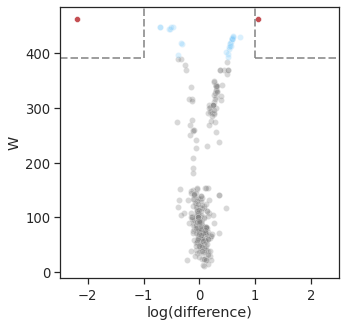

In [10]:
sns.set(rc={'figure.figsize':(5, 5)}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    ax = sns.scatterplot(
        data= ancomDataSig[(ancomDataSig['Reject null hypothesis'] == False)], 
        x='log', 
        y='W',
        color='grey',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>-1)], 
        x='log', 
        y='W',
        color='lightskyblue',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']<-1)], 
        x='log', 
        y='W',
        color='r'
    )
    ax = sns.scatterplot(
        data=ancomDataSig[(ancomDataSig['Reject null hypothesis'] == True) & (ancomDataSig['log']>1)], 
        x='log', 
        y='W',
        color='r'
    )
ax.tick_params(axis='x', which='major', bottom=True)
ax.tick_params(axis='y', which='major', left=True)
ax.set_xlim(-2.5,2.5)
#ax.set_ylim(-5,5200)
#ax.set_yscale('log')
ax.set_xlabel('log(difference)')
ax.axhline(y=391, xmin=0, xmax=.3, color="grey", dashes=(5, 2))
ax.axhline(y=391, xmin=.7, xmax=1, color="grey", dashes=(5, 2))
ax.axvline(x=1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.axvline(x=-1, ymin=0.81, ymax=1, color="grey", dashes=(5, 2))
ax.set_ylabel('W')
#plt.savefig(f'{picrust_dir}/figures/Vulcano_picrustDelMode_600dpi.png', bbox_inches='tight', dpi=600)

In [24]:
! qiime feature-table filter-samples \
    --i-table $picrust_dir/pjnb-path-abund-vag-ces.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --p-where "[age_months] <= 6" \
    --o-filtered-table $picrust_dir/pjnb-path-abund-vag-ces-6m.qza

Saved FeatureTable[Frequency] to: data/picrust_del/pjnb-path-abund-vag-ces-6m.qza


In [25]:
! qiime composition add-pseudocount \
    --i-table $picrust_dir/pjnb-path-abund-vag-ces-6m.qza \
    --o-composition-table $picrust_dir/pjnb-path-abund-vag-ces-abund-6m.qza

Saved FeatureTable[Composition] to: data/picrust_del/pjnb-path-abund-vag-ces-abund-6m.qza


In [26]:
! qiime composition ancom \
    --i-table $picrust_dir/pjnb-path-abund-vag-ces-abund-6m.qza \
    --m-metadata-file $or_dir/metadata.tsv \
    --m-metadata-column delivery_mode \
    --p-transform-function log \
    --o-visualization $picrust_dir/pjnb-path-abund-vag-ces-ancom-6m.qzv

Saved Visualization to: data/picrust_del/pjnb-path-abund-vag-ces-ancom-6m.qzv


In [27]:
Visualization.load(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom-6m.qzv')

<visualization: Visualization uuid: dbb76d6a-76dd-4409-956a-4a44a91f26f2>

In [28]:
! qiime tools extract \
    --input-path $picrust_dir/pjnb-path-abund-vag-ces-ancom-6m.qzv \
    --output-path $picrust_dir/pjnb-path-abund-vag-ces-ancom-6m

Extracted data/picrust_del/pjnb-path-abund-vag-ces-ancom-6m.qzv to directory data/picrust_del/pjnb-path-abund-vag-ces-ancom-6m/dbb76d6a-76dd-4409-956a-4a44a91f26f2


In [8]:
ancomData6m = pd.read_csv(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom-6m/dbb76d6a-76dd-4409-956a-4a44a91f26f2/data/data.tsv', sep='\t')
ancomSignificance6m = pd.read_csv(f'{picrust_dir}/pjnb-path-abund-vag-ces-ancom-6m/dbb76d6a-76dd-4409-956a-4a44a91f26f2/data/ancom.tsv', sep='\t')
ancomSignificance6m.rename(columns = {'Unnamed: 0':'id'}, inplace = True)

In [9]:
ancomDataSig6m = ancomData6m.merge(ancomSignificance6m, how='inner')
ancomDataSig6m

,id,log,W,Reject null hypothesis
0,1CMET2-PWY,0.021296,26,False
1,3-HYDROXYPHENYLACETATE-DEGRADATION-PWY,-0.614026,249,False
2,AEROBACTINSYN-PWY,-0.864221,13,False
3,ALL-CHORISMATE-PWY,-0.553163,306,False
4,ANAEROFRUCAT-PWY,0.045017,44,False
...,...,...,...,...
447,TYRFUMCAT-PWY,0.038749,1,False
448,UBISYN-PWY,-0.432670,85,False
449,UDPNAGSYN-PWY,0.025750,24,False
450,VALDEG-PWY,0.155542,27,False


In [10]:
ancomDataSig6m.sort_values(by='log', axis=0, ascending=True)

,id,log,W,Reject null hypothesis
2,AEROBACTINSYN-PWY,-0.864221,13,False
13,AST-PWY,-0.793288,395,False
389,PWY-7446,-0.728324,356,False
89,ORNDEG-PWY,-0.727741,355,False
88,ORNARGDEG-PWY,-0.716825,98,False
...,...,...,...,...
257,PWY-6263,0.866963,388,False
378,PWY-7371,0.894311,411,True
337,PWY-7090,1.044226,417,True
390,PWY-7456,1.137496,420,True


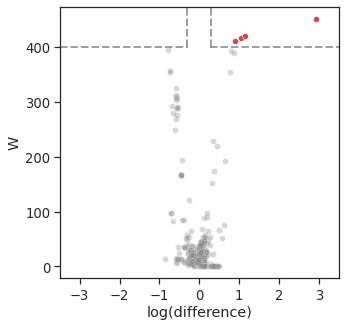

In [14]:
sns.set(rc={'figure.figsize':(5, 5)}, style='white')
with sns.plotting_context("notebook", font_scale=1.2):
    ax = sns.scatterplot(
        data= ancomDataSig6m[(ancomDataSig6m['Reject null hypothesis'] == False)], 
        x='log', 
        y='W',
        color='grey',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig6m[(ancomDataSig6m['Reject null hypothesis'] == True) & (ancomDataSig6m['log']<0.3)], 
        x='log', 
        y='W',
        color='lightskyblue',
        alpha=.3
    )
    ax = sns.scatterplot(
        data=ancomDataSig6m[(ancomDataSig6m['Reject null hypothesis'] == True) & (ancomDataSig6m['log']>=0.3)], 
        x='log', 
        y='W',
        color='r'
    )
ax.tick_params(axis='x', which='major', bottom=True)
ax.tick_params(axis='y', which='major', left=True)
ax.set_xlim(-3.5,3.5)
#ax.set_ylim(-5,5200)
#ax.set_yscale('log')
ax.set_xlabel('log(difference)')
ax.axhline(y=400, xmin=0, xmax=.46, color="grey", dashes=(5, 2))
ax.axhline(y=400, xmin=.54, xmax=1, color="grey", dashes=(5, 2))
ax.axvline(x=0.3, ymin=0.85, ymax=1, color="grey", dashes=(5, 2))
ax.axvline(x=-0.3, ymin=0.85, ymax=1, color="grey", dashes=(5, 2))
ax.set_ylabel('W')
plt.savefig(f'{picrust_dir}/figures/Vulcano_picrustDelMode6m_600dpi.png', bbox_inches='tight', dpi=600)